In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os
import sys

sns.set_style("white")
sns.set_palette("husl")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [3]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                          self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, {}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        if self.seed:
            label += ", seed-{}".format(self.seed)
        else:
            label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * .90})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [4]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         xmax=None,
         ymarker=None):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)
        print(config.label)
        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            plt.ylim(ymin, local_ymax)
            
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
    
        format_plot(xlabel, ylabel)
        write_file(plot_prefix, show=True)




In [5]:
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymarker=None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop / 1000000. \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]

            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Aggregate Ratio Backpropped", plot_dir, smoothing, lw=3, ymin=0, xmax=xmax)
    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, xmax=xmax, ymarker=ymarker)
    plot(test_num_inferences_by_config, test_accuracies_by_config, "Num Images Forward Propped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, xmax=xmax, ymarker=ymarker)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [6]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181115_seedednew_aug"
baseline_file = "deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2"
do_plot = False
do_evaluate = True

plot_dir = "{}/sb_l2_dist/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = [baseline_exp]
experiment_names.append("181115_seedednew_aug")
experiment_names.append("181105_debug_lite")

if do_plot:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1])

baseline_path = os.path.join(experiment_dir, baseline_exp, baseline_file)
if do_evaluate:
    print "------------------181115_seedednew_aug---------------------"
    Evaluate.evaluate(experiment_dir,
             baseline_exp,
             baseline_file,
             ["181115_seedednew_aug"],
             ["deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2"])


------------------181115_seedednew_aug---------------------
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Final Accuracy: 95.18
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
Final Accuracy: 95.6
AUC Difference: 0.833527127812
0.76X More Backprops
2.07X More Forward Props


deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 915 915
181115_forwardlr_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Aggregate Ratio Backpropped 974 974
181127_scaled, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (m

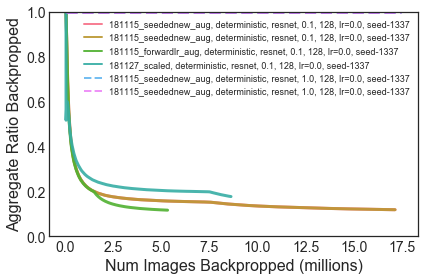

Num Images Backpropped (millions) , Training Loss 135285 135285
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Training Loss 135285 135285
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Training Loss 42074 42074
181115_forwardlr_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Training Loss 67802 67802
181127_scaled, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Training Loss 136850 136850
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Training Loss 136850 136850
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
../plots/181127//181115_seedednew_aug_Num Images Backpropped (millions)_Training Loss_lr0.0.pdf


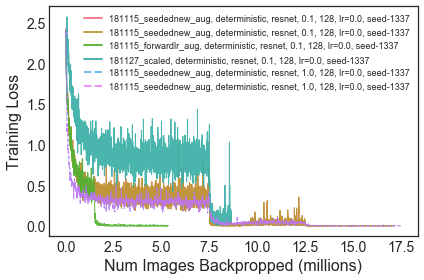

Num Images Backpropped (millions) , Test Accuracy 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Accuracy 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Accuracy 915 915
181115_forwardlr_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Accuracy 975 975
181127_scaled, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Accuracy 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Accuracy 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
../plots/181127//181115_seedednew_aug_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


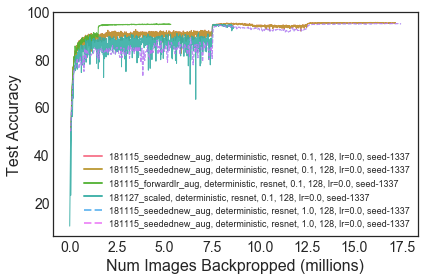

Num Images Forward Propped (millions) , Test Accuracy 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Forward Propped (millions) , Test Accuracy 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Forward Propped (millions) , Test Accuracy 915 915
181115_forwardlr_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Forward Propped (millions) , Test Accuracy 975 975
181127_scaled, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Forward Propped (millions) , Test Accuracy 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
Num Images Forward Propped (millions) , Test Accuracy 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
../plots/181127//181115_seedednew_aug_Num Images Forward Propped (millions)_Test Accuracy_lr0.0.pdf


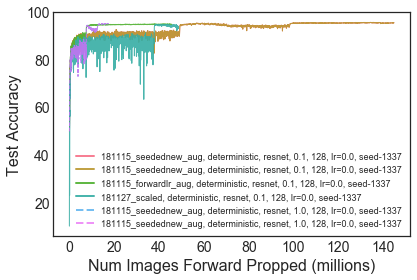

Num Images Backpropped (millions) , Test Loss 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Loss 2895 2895
181115_seedednew_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Loss 915 915
181115_forwardlr_aug, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Loss 975 975
181127_scaled, deterministic, resnet, 0.1, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Loss 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
Num Images Backpropped (millions) , Test Loss 349 349
181115_seedednew_aug, deterministic, resnet, 1.0, 128, lr=0.0, seed-1337
../plots/181127//181115_seedednew_aug_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


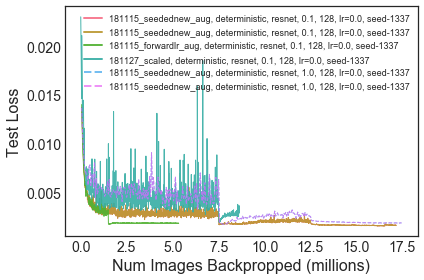

------------------181115_seedednew_aug---------------------
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Final Accuracy: 95.18
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
Final Accuracy: 95.6
AUC Difference: 0.833527127812
0.76X More Backprops
2.07X More Forward Props
------------------181127_scaled---------------------
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Final Accuracy: 95.18
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
Final Accuracy: 94.79
AUC Difference: 0.214777751922
0.89X More Backprops
2.49X More Forward Props
------------------181115_forwardlr_aug---------------------
deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Final Accuracy: 95.18
deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2
Final Accuracy: 94.97
AUC Difference: 0.147982155552
0.60X More Backprops
0.98X More Forward Props


<Figure size 432x288 with 0 Axes>

In [10]:
plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10"
baseline_exp = "181115_seedednew_aug"
baseline_file = "deterministic_cifar10_resnet_1_128_0.0_0.0005_trial1_seed1337_v2"
do_plot = True
do_evaluate = True

plot_dir = "{}/181127/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = [baseline_exp]
experiment_names.append("181115_seedednew_aug")
experiment_names.append("181127_scaled")
experiment_names.append("181115_forwardlr_aug")

if do_plot:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     trials=[1])

baseline_path = os.path.join(experiment_dir, baseline_exp, baseline_file)
if do_evaluate:
    print "------------------181115_seedednew_aug---------------------"
    Evaluate.evaluate(experiment_dir,
             baseline_exp,
             baseline_file,
             ["181115_seedednew_aug"],
             ["deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2"])
    print "------------------181127_scaled---------------------"
    Evaluate.evaluate(experiment_dir,
             baseline_exp,
             baseline_file,
             ["181127_scaled"],
             ["deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2"])
    print "------------------181115_forwardlr_aug---------------------"
    Evaluate.evaluate(experiment_dir,
             baseline_exp,
             baseline_file,
             ["181115_forwardlr_aug"],
             ["deterministic_cifar10_resnet_0.1_128_0.0_0.0005_trial1_seed1337_v2"])

